##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 애드온 옵티마이저: ConditionalGradient

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/addons/tutorials/optimizers_conditionalgradient"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/addons/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/addons/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/addons/tutorials/optimizers_conditionalgradient.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

# 개요

이 노트북은 애드온 패키지에서 Conditional Graident 옵티마이저를 사용하는 방법을 보여줍니다.

# ConditionalGradient

> 신경망의 매개변수를 제한하면 기본적인 정규화 효과로 인해 훈련에 유익한 것으로 나타났습니다. 종종 매개변수는 소프트 페널티(제약 조건 만족을 보장하지 않음) 또는 프로젝션 연산(계산적으로 비쌈)을 통해 제한됩니다. 반면에 CG(Conditional Gradient) 옵티마이저는 값 비싼 프로젝션 단계 없이 제약 조건을 엄격하게 적용합니다. 제약 조건 세트 내에서 목표의 선형 근사치를 최소화하여 동작합니다. 이 노트북의 MNIST 데이터세트에서 CG 옵티마이저를 통해 Frobenius norm 제약 조건의 적용을 보여줍니다. CG는 이제 tensorflow API로 사용 가능합니다. 옵티마이저에 대한 자세한 내용은 https://arxiv.org/pdf/1803.06453.pdf를 참조하세요.


## 설정

In [2]:
!pip install -q -U tensorflow-addons

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt

In [4]:
# Hyperparameters
batch_size=64
epochs=10

# 모델 빌드하기

In [5]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

# 데이터 준비하기

In [6]:
# Load MNIST dataset as NumPy arrays
dataset = {}
num_validation = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 784).astype('float32') / 255
x_test = x_test.reshape(-1, 784).astype('float32') / 255

# 사용자 정의 콜백 함수 정의하기

In [7]:
def frobenius_norm(m):
    """This function is to calculate the frobenius norm of the matrix of all
    layer's weight.
  
    Args:
        m: is a list of weights param for each layers.
    """
    total_reduce_sum = 0
    for i in range(len(m)):
        total_reduce_sum = total_reduce_sum + tf.math.reduce_sum(m[i]**2)
    norm = total_reduce_sum**0.5
    return norm

In [8]:
CG_frobenius_norm_of_weight = []
CG_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: CG_frobenius_norm_of_weight.append(
        frobenius_norm(model_1.trainable_weights).numpy()))

# 훈련 및 평가: CG를 옵티마이저로 사용하기

일반적인 keras 옵티마이저를 새로운 tfa 옵티마이저로 간단히 교체합니다. 

In [9]:
# Compile the model
model_1.compile(
    optimizer=tfa.optimizers.ConditionalGradient(
        learning_rate=0.99949, lambda_=203),  # Utilize TFA optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_cg = model_1.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[CG_get_weight_norm])

Epoch 1/10


  1/938 [..............................] - ETA: 0s - loss: 2.4011 - accuracy: 0.0625

 23/938 [..............................] - ETA: 2s - loss: 1.7177 - accuracy: 0.4762

 46/938 [>.............................] - ETA: 1s - loss: 1.2935 - accuracy: 0.6084

 69/938 [=>............................] - ETA: 1s - loss: 1.0851 - accuracy: 0.6680

 92/938 [=>............................] - ETA: 1s - loss: 0.9598 - accuracy: 0.7048

115/938 [==>...........................] - ETA: 1s - loss: 0.8643 - accuracy: 0.7336

138/938 [===>..........................] - ETA: 1s - loss: 0.7978 - accuracy: 0.7565

160/938 [====>.........................] - ETA: 1s - loss: 0.7480 - accuracy: 0.7711

182/938 [====>.........................] - ETA: 1s - loss: 0.7097 - accuracy: 0.7831

205/938 [=====>........................] - ETA: 1s - loss: 0.6701 - accuracy: 0.7961

228/938 [======>.......................] - ETA: 1s - loss: 0.6414 - accuracy: 0.8048

250/938 [======>.......................] - ETA: 1s - loss: 0.6176 - accuracy: 0.8117

272/938 [=======>......................] - ETA: 1s - loss: 0.5976 - accuracy: 0.8185

294/938 [========>.....................] - ETA: 1s - loss: 0.5824 - accuracy: 0.8230

317/938 [=========>....................] - ETA: 1s - loss: 0.5673 - accuracy: 0.8279

340/938 [=========>....................] - ETA: 1s - loss: 0.5542 - accuracy: 0.8326

363/938 [==========>...................] - ETA: 1s - loss: 0.5435 - accuracy: 0.8361

386/938 [===========>..................] - ETA: 1s - loss: 0.5283 - accuracy: 0.8406

409/938 [============>.................] - ETA: 1s - loss: 0.5184 - accuracy: 0.8434

432/938 [============>.................] - ETA: 1s - loss: 0.5079 - accuracy: 0.8462

455/938 [=============>................] - ETA: 1s - loss: 0.4972 - accuracy: 0.8494

478/938 [==============>...............] - ETA: 1s - loss: 0.4878 - accuracy: 0.8522

501/938 [===============>..............] - ETA: 0s - loss: 0.4793 - accuracy: 0.8548

523/938 [===============>..............] - ETA: 0s - loss: 0.4702 - accuracy: 0.8573

545/938 [================>.............] - ETA: 0s - loss: 0.4633 - accuracy: 0.8598

567/938 [=================>............] - ETA: 0s - loss: 0.4564 - accuracy: 0.8616

590/938 [=================>............] - ETA: 0s - loss: 0.4492 - accuracy: 0.8640

612/938 [==================>...........] - ETA: 0s - loss: 0.4438 - accuracy: 0.8657

633/938 [===================>..........] - ETA: 0s - loss: 0.4385 - accuracy: 0.8675

655/938 [===================>..........] - ETA: 0s - loss: 0.4331 - accuracy: 0.8693

677/938 [====================>.........] - ETA: 0s - loss: 0.4271 - accuracy: 0.8708

699/938 [=====================>........] - ETA: 0s - loss: 0.4222 - accuracy: 0.8725

722/938 [======================>.......] - ETA: 0s - loss: 0.4166 - accuracy: 0.8741

745/938 [======================>.......] - ETA: 0s - loss: 0.4121 - accuracy: 0.8756

767/938 [=======================>......] - ETA: 0s - loss: 0.4084 - accuracy: 0.8766

789/938 [========================>.....] - ETA: 0s - loss: 0.4038 - accuracy: 0.8780

811/938 [========================>.....] - ETA: 0s - loss: 0.3993 - accuracy: 0.8793

833/938 [=========================>....] - ETA: 0s - loss: 0.3948 - accuracy: 0.8808

855/938 [==========================>...] - ETA: 0s - loss: 0.3910 - accuracy: 0.8820

878/938 [===========================>..] - ETA: 0s - loss: 0.3876 - accuracy: 0.8828

901/938 [===========================>..] - ETA: 0s - loss: 0.3836 - accuracy: 0.8841

923/938 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8851

938/938 [==============================] - 3s 3ms/step - loss: 0.3775 - accuracy: 0.8859 - val_loss: 0.2121 - val_accuracy: 0.9358


Epoch 2/10
  1/938 [..............................] - ETA: 0s - loss: 0.1212 - accuracy: 0.9688

 24/938 [..............................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9355

 47/938 [>.............................] - ETA: 1s - loss: 0.1951 - accuracy: 0.9441

 69/938 [=>............................] - ETA: 1s - loss: 0.2118 - accuracy: 0.9375

 92/938 [=>............................] - ETA: 1s - loss: 0.2144 - accuracy: 0.9361

114/938 [==>...........................] - ETA: 1s - loss: 0.2140 - accuracy: 0.9357

136/938 [===>..........................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9354

159/938 [====>.........................] - ETA: 1s - loss: 0.2181 - accuracy: 0.9347

182/938 [====>.........................] - ETA: 1s - loss: 0.2142 - accuracy: 0.9351

204/938 [=====>........................] - ETA: 1s - loss: 0.2160 - accuracy: 0.9347

226/938 [======>.......................] - ETA: 1s - loss: 0.2165 - accuracy: 0.9348

248/938 [======>.......................] - ETA: 1s - loss: 0.2160 - accuracy: 0.9350

270/938 [=======>......................] - ETA: 1s - loss: 0.2127 - accuracy: 0.9360

291/938 [========>.....................] - ETA: 1s - loss: 0.2105 - accuracy: 0.9364

314/938 [=========>....................] - ETA: 1s - loss: 0.2100 - accuracy: 0.9365

335/938 [=========>....................] - ETA: 1s - loss: 0.2074 - accuracy: 0.9373

358/938 [==========>...................] - ETA: 1s - loss: 0.2090 - accuracy: 0.9368

381/938 [===========>..................] - ETA: 1s - loss: 0.2061 - accuracy: 0.9377

404/938 [===========>..................] - ETA: 1s - loss: 0.2057 - accuracy: 0.9380

427/938 [============>.................] - ETA: 1s - loss: 0.2032 - accuracy: 0.9386

450/938 [=============>................] - ETA: 1s - loss: 0.2013 - accuracy: 0.9392

474/938 [==============>...............] - ETA: 1s - loss: 0.2004 - accuracy: 0.9393

496/938 [==============>...............] - ETA: 1s - loss: 0.2002 - accuracy: 0.9393

519/938 [===============>..............] - ETA: 0s - loss: 0.1989 - accuracy: 0.9398

541/938 [================>.............] - ETA: 0s - loss: 0.1996 - accuracy: 0.9396

563/938 [=================>............] - ETA: 0s - loss: 0.1993 - accuracy: 0.9398

586/938 [=================>............] - ETA: 0s - loss: 0.1976 - accuracy: 0.9404

607/938 [==================>...........] - ETA: 0s - loss: 0.1982 - accuracy: 0.9403

629/938 [===================>..........] - ETA: 0s - loss: 0.1978 - accuracy: 0.9406

651/938 [===================>..........] - ETA: 0s - loss: 0.1977 - accuracy: 0.9406

674/938 [====================>.........] - ETA: 0s - loss: 0.1973 - accuracy: 0.9407

697/938 [=====================>........] - ETA: 0s - loss: 0.1973 - accuracy: 0.9408

719/938 [=====================>........] - ETA: 0s - loss: 0.1975 - accuracy: 0.9407

741/938 [======================>.......] - ETA: 0s - loss: 0.1959 - accuracy: 0.9411

764/938 [=======================>......] - ETA: 0s - loss: 0.1957 - accuracy: 0.9413

787/938 [========================>.....] - ETA: 0s - loss: 0.1951 - accuracy: 0.9414

809/938 [========================>.....] - ETA: 0s - loss: 0.1947 - accuracy: 0.9414

832/938 [=========================>....] - ETA: 0s - loss: 0.1940 - accuracy: 0.9417

854/938 [==========================>...] - ETA: 0s - loss: 0.1939 - accuracy: 0.9416

877/938 [===========================>..] - ETA: 0s - loss: 0.1936 - accuracy: 0.9417

899/938 [===========================>..] - ETA: 0s - loss: 0.1925 - accuracy: 0.9421

921/938 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9422

938/938 [==============================] - 2s 3ms/step - loss: 0.1916 - accuracy: 0.9423 - val_loss: 0.1583 - val_accuracy: 0.9516


Epoch 3/10
  1/938 [..............................] - ETA: 0s - loss: 0.1823 - accuracy: 0.9375

 24/938 [..............................] - ETA: 1s - loss: 0.1629 - accuracy: 0.9492

 46/938 [>.............................] - ETA: 1s - loss: 0.1556 - accuracy: 0.9518

 69/938 [=>............................] - ETA: 1s - loss: 0.1582 - accuracy: 0.9504

 92/938 [=>............................] - ETA: 1s - loss: 0.1601 - accuracy: 0.9507

114/938 [==>...........................] - ETA: 1s - loss: 0.1586 - accuracy: 0.9508

136/938 [===>..........................] - ETA: 1s - loss: 0.1546 - accuracy: 0.9535

159/938 [====>.........................] - ETA: 1s - loss: 0.1541 - accuracy: 0.9536

181/938 [====>.........................] - ETA: 1s - loss: 0.1523 - accuracy: 0.9540

203/938 [=====>........................] - ETA: 1s - loss: 0.1519 - accuracy: 0.9543

225/938 [======>.......................] - ETA: 1s - loss: 0.1530 - accuracy: 0.9535

248/938 [======>.......................] - ETA: 1s - loss: 0.1530 - accuracy: 0.9535

270/938 [=======>......................] - ETA: 1s - loss: 0.1539 - accuracy: 0.9530

293/938 [========>.....................] - ETA: 1s - loss: 0.1522 - accuracy: 0.9538

316/938 [=========>....................] - ETA: 1s - loss: 0.1531 - accuracy: 0.9536

338/938 [=========>....................] - ETA: 1s - loss: 0.1537 - accuracy: 0.9535

361/938 [==========>...................] - ETA: 1s - loss: 0.1534 - accuracy: 0.9537

383/938 [===========>..................] - ETA: 1s - loss: 0.1535 - accuracy: 0.9540

406/938 [===========>..................] - ETA: 1s - loss: 0.1527 - accuracy: 0.9542

428/938 [============>.................] - ETA: 1s - loss: 0.1524 - accuracy: 0.9543

451/938 [=============>................] - ETA: 1s - loss: 0.1527 - accuracy: 0.9542

474/938 [==============>...............] - ETA: 1s - loss: 0.1524 - accuracy: 0.9545

497/938 [==============>...............] - ETA: 0s - loss: 0.1537 - accuracy: 0.9542

519/938 [===============>..............] - ETA: 0s - loss: 0.1541 - accuracy: 0.9539

542/938 [================>.............] - ETA: 0s - loss: 0.1545 - accuracy: 0.9539

564/938 [=================>............] - ETA: 0s - loss: 0.1542 - accuracy: 0.9538

587/938 [=================>............] - ETA: 0s - loss: 0.1541 - accuracy: 0.9540

610/938 [==================>...........] - ETA: 0s - loss: 0.1544 - accuracy: 0.9538

633/938 [===================>..........] - ETA: 0s - loss: 0.1541 - accuracy: 0.9537

657/938 [====================>.........] - ETA: 0s - loss: 0.1535 - accuracy: 0.9539

680/938 [====================>.........] - ETA: 0s - loss: 0.1534 - accuracy: 0.9540

703/938 [=====================>........] - ETA: 0s - loss: 0.1535 - accuracy: 0.9541

725/938 [======================>.......] - ETA: 0s - loss: 0.1529 - accuracy: 0.9542

747/938 [======================>.......] - ETA: 0s - loss: 0.1532 - accuracy: 0.9541

769/938 [=======================>......] - ETA: 0s - loss: 0.1531 - accuracy: 0.9541

792/938 [========================>.....] - ETA: 0s - loss: 0.1533 - accuracy: 0.9540

815/938 [=========================>....] - ETA: 0s - loss: 0.1533 - accuracy: 0.9539

837/938 [=========================>....] - ETA: 0s - loss: 0.1529 - accuracy: 0.9540

860/938 [==========================>...] - ETA: 0s - loss: 0.1525 - accuracy: 0.9542

883/938 [===========================>..] - ETA: 0s - loss: 0.1531 - accuracy: 0.9540

906/938 [===========================>..] - ETA: 0s - loss: 0.1530 - accuracy: 0.9541

929/938 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9541

938/938 [==============================] - 2s 3ms/step - loss: 0.1533 - accuracy: 0.9540 - val_loss: 0.1763 - val_accuracy: 0.9428


Epoch 4/10
  1/938 [..............................] - ETA: 0s - loss: 0.1270 - accuracy: 0.9688

 23/938 [..............................] - ETA: 2s - loss: 0.1408 - accuracy: 0.9613

 45/938 [>.............................] - ETA: 2s - loss: 0.1326 - accuracy: 0.9628

 67/938 [=>............................] - ETA: 1s - loss: 0.1391 - accuracy: 0.9608

 90/938 [=>............................] - ETA: 1s - loss: 0.1379 - accuracy: 0.9622

112/938 [==>...........................] - ETA: 1s - loss: 0.1365 - accuracy: 0.9614

134/938 [===>..........................] - ETA: 1s - loss: 0.1342 - accuracy: 0.9612

156/938 [===>..........................] - ETA: 1s - loss: 0.1340 - accuracy: 0.9609

178/938 [====>.........................] - ETA: 1s - loss: 0.1320 - accuracy: 0.9615

200/938 [=====>........................] - ETA: 1s - loss: 0.1345 - accuracy: 0.9600

223/938 [======>.......................] - ETA: 1s - loss: 0.1354 - accuracy: 0.9594

245/938 [======>.......................] - ETA: 1s - loss: 0.1360 - accuracy: 0.9592

268/938 [=======>......................] - ETA: 1s - loss: 0.1360 - accuracy: 0.9594

291/938 [========>.....................] - ETA: 1s - loss: 0.1353 - accuracy: 0.9594

313/938 [=========>....................] - ETA: 1s - loss: 0.1355 - accuracy: 0.9594

336/938 [=========>....................] - ETA: 1s - loss: 0.1354 - accuracy: 0.9594

359/938 [==========>...................] - ETA: 1s - loss: 0.1353 - accuracy: 0.9593

382/938 [===========>..................] - ETA: 1s - loss: 0.1366 - accuracy: 0.9589

404/938 [===========>..................] - ETA: 1s - loss: 0.1360 - accuracy: 0.9588

426/938 [============>.................] - ETA: 1s - loss: 0.1367 - accuracy: 0.9584

448/938 [=============>................] - ETA: 1s - loss: 0.1362 - accuracy: 0.9585

470/938 [==============>...............] - ETA: 1s - loss: 0.1367 - accuracy: 0.9587

493/938 [==============>...............] - ETA: 1s - loss: 0.1351 - accuracy: 0.9591

515/938 [===============>..............] - ETA: 0s - loss: 0.1356 - accuracy: 0.9588

537/938 [================>.............] - ETA: 0s - loss: 0.1354 - accuracy: 0.9589

559/938 [================>.............] - ETA: 0s - loss: 0.1358 - accuracy: 0.9587

581/938 [=================>............] - ETA: 0s - loss: 0.1361 - accuracy: 0.9588

603/938 [==================>...........] - ETA: 0s - loss: 0.1353 - accuracy: 0.9589

626/938 [===================>..........] - ETA: 0s - loss: 0.1347 - accuracy: 0.9590

648/938 [===================>..........] - ETA: 0s - loss: 0.1346 - accuracy: 0.9593

671/938 [====================>.........] - ETA: 0s - loss: 0.1351 - accuracy: 0.9591

693/938 [=====================>........] - ETA: 0s - loss: 0.1350 - accuracy: 0.9594

716/938 [=====================>........] - ETA: 0s - loss: 0.1353 - accuracy: 0.9593

738/938 [======================>.......] - ETA: 0s - loss: 0.1352 - accuracy: 0.9593

760/938 [=======================>......] - ETA: 0s - loss: 0.1347 - accuracy: 0.9594

781/938 [=======================>......] - ETA: 0s - loss: 0.1350 - accuracy: 0.9594

803/938 [========================>.....] - ETA: 0s - loss: 0.1347 - accuracy: 0.9594

824/938 [=========================>....] - ETA: 0s - loss: 0.1347 - accuracy: 0.9593

846/938 [==========================>...] - ETA: 0s - loss: 0.1343 - accuracy: 0.9593

867/938 [==========================>...] - ETA: 0s - loss: 0.1355 - accuracy: 0.9592

888/938 [===========================>..] - ETA: 0s - loss: 0.1353 - accuracy: 0.9592

911/938 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9593

933/938 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9596

938/938 [==============================] - 2s 3ms/step - loss: 0.1347 - accuracy: 0.9595 - val_loss: 0.1292 - val_accuracy: 0.9601


Epoch 5/10
  1/938 [..............................] - ETA: 0s - loss: 0.1183 - accuracy: 0.9844

 23/938 [..............................] - ETA: 1s - loss: 0.1373 - accuracy: 0.9572

 46/938 [>.............................] - ETA: 1s - loss: 0.1192 - accuracy: 0.9630

 68/938 [=>............................] - ETA: 1s - loss: 0.1129 - accuracy: 0.9653

 89/938 [=>............................] - ETA: 1s - loss: 0.1159 - accuracy: 0.9640

111/938 [==>...........................] - ETA: 1s - loss: 0.1147 - accuracy: 0.9645

133/938 [===>..........................] - ETA: 1s - loss: 0.1184 - accuracy: 0.9636

155/938 [===>..........................] - ETA: 1s - loss: 0.1169 - accuracy: 0.9644

178/938 [====>.........................] - ETA: 1s - loss: 0.1197 - accuracy: 0.9642

200/938 [=====>........................] - ETA: 1s - loss: 0.1211 - accuracy: 0.9635

222/938 [======>.......................] - ETA: 1s - loss: 0.1208 - accuracy: 0.9638

244/938 [======>.......................] - ETA: 1s - loss: 0.1195 - accuracy: 0.9641

266/938 [=======>......................] - ETA: 1s - loss: 0.1209 - accuracy: 0.9634

289/938 [========>.....................] - ETA: 1s - loss: 0.1217 - accuracy: 0.9632

312/938 [========>.....................] - ETA: 1s - loss: 0.1219 - accuracy: 0.9632

335/938 [=========>....................] - ETA: 1s - loss: 0.1222 - accuracy: 0.9631

357/938 [==========>...................] - ETA: 1s - loss: 0.1219 - accuracy: 0.9633

379/938 [===========>..................] - ETA: 1s - loss: 0.1230 - accuracy: 0.9630

402/938 [===========>..................] - ETA: 1s - loss: 0.1220 - accuracy: 0.9632

425/938 [============>.................] - ETA: 1s - loss: 0.1220 - accuracy: 0.9635

448/938 [=============>................] - ETA: 1s - loss: 0.1227 - accuracy: 0.9634

470/938 [==============>...............] - ETA: 1s - loss: 0.1231 - accuracy: 0.9632

493/938 [==============>...............] - ETA: 1s - loss: 0.1237 - accuracy: 0.9630

516/938 [===============>..............] - ETA: 0s - loss: 0.1237 - accuracy: 0.9629

538/938 [================>.............] - ETA: 0s - loss: 0.1238 - accuracy: 0.9629

560/938 [================>.............] - ETA: 0s - loss: 0.1238 - accuracy: 0.9628

582/938 [=================>............] - ETA: 0s - loss: 0.1233 - accuracy: 0.9629

604/938 [==================>...........] - ETA: 0s - loss: 0.1232 - accuracy: 0.9631

626/938 [===================>..........] - ETA: 0s - loss: 0.1233 - accuracy: 0.9631

649/938 [===================>..........] - ETA: 0s - loss: 0.1231 - accuracy: 0.9632

672/938 [====================>.........] - ETA: 0s - loss: 0.1229 - accuracy: 0.9632

694/938 [=====================>........] - ETA: 0s - loss: 0.1227 - accuracy: 0.9632

716/938 [=====================>........] - ETA: 0s - loss: 0.1223 - accuracy: 0.9632

738/938 [======================>.......] - ETA: 0s - loss: 0.1213 - accuracy: 0.9636

760/938 [=======================>......] - ETA: 0s - loss: 0.1213 - accuracy: 0.9636

783/938 [========================>.....] - ETA: 0s - loss: 0.1215 - accuracy: 0.9635

805/938 [========================>.....] - ETA: 0s - loss: 0.1210 - accuracy: 0.9638

827/938 [=========================>....] - ETA: 0s - loss: 0.1212 - accuracy: 0.9636

850/938 [==========================>...] - ETA: 0s - loss: 0.1217 - accuracy: 0.9632

872/938 [==========================>...] - ETA: 0s - loss: 0.1219 - accuracy: 0.9631

894/938 [===========================>..] - ETA: 0s - loss: 0.1219 - accuracy: 0.9630

916/938 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9628

938/938 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9627

938/938 [==============================] - 2s 3ms/step - loss: 0.1226 - accuracy: 0.9627 - val_loss: 0.1129 - val_accuracy: 0.9661


Epoch 6/10
  1/938 [..............................] - ETA: 0s - loss: 0.0834 - accuracy: 0.9844

 24/938 [..............................] - ETA: 1s - loss: 0.1067 - accuracy: 0.9655

 46/938 [>.............................] - ETA: 1s - loss: 0.1061 - accuracy: 0.9667

 69/938 [=>............................] - ETA: 1s - loss: 0.1041 - accuracy: 0.9674

 92/938 [=>............................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9677

115/938 [==>...........................] - ETA: 1s - loss: 0.1102 - accuracy: 0.9670

138/938 [===>..........................] - ETA: 1s - loss: 0.1100 - accuracy: 0.9668

161/938 [====>.........................] - ETA: 1s - loss: 0.1105 - accuracy: 0.9665

184/938 [====>.........................] - ETA: 1s - loss: 0.1131 - accuracy: 0.9660

207/938 [=====>........................] - ETA: 1s - loss: 0.1102 - accuracy: 0.9675

228/938 [======>.......................] - ETA: 1s - loss: 0.1112 - accuracy: 0.9670

250/938 [======>.......................] - ETA: 1s - loss: 0.1097 - accuracy: 0.9673

273/938 [=======>......................] - ETA: 1s - loss: 0.1116 - accuracy: 0.9664

295/938 [========>.....................] - ETA: 1s - loss: 0.1131 - accuracy: 0.9659

318/938 [=========>....................] - ETA: 1s - loss: 0.1140 - accuracy: 0.9656

341/938 [=========>....................] - ETA: 1s - loss: 0.1145 - accuracy: 0.9657

363/938 [==========>...................] - ETA: 1s - loss: 0.1147 - accuracy: 0.9658

385/938 [===========>..................] - ETA: 1s - loss: 0.1143 - accuracy: 0.9657

407/938 [============>.................] - ETA: 1s - loss: 0.1150 - accuracy: 0.9655

429/938 [============>.................] - ETA: 1s - loss: 0.1146 - accuracy: 0.9654

450/938 [=============>................] - ETA: 1s - loss: 0.1151 - accuracy: 0.9648

472/938 [==============>...............] - ETA: 1s - loss: 0.1150 - accuracy: 0.9648

495/938 [==============>...............] - ETA: 1s - loss: 0.1143 - accuracy: 0.9648

518/938 [===============>..............] - ETA: 0s - loss: 0.1148 - accuracy: 0.9644

541/938 [================>.............] - ETA: 0s - loss: 0.1148 - accuracy: 0.9646

563/938 [=================>............] - ETA: 0s - loss: 0.1143 - accuracy: 0.9650

586/938 [=================>............] - ETA: 0s - loss: 0.1140 - accuracy: 0.9649

609/938 [==================>...........] - ETA: 0s - loss: 0.1142 - accuracy: 0.9649

631/938 [===================>..........] - ETA: 0s - loss: 0.1153 - accuracy: 0.9645

654/938 [===================>..........] - ETA: 0s - loss: 0.1157 - accuracy: 0.9642

677/938 [====================>.........] - ETA: 0s - loss: 0.1157 - accuracy: 0.9642

700/938 [=====================>........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9645

722/938 [======================>.......] - ETA: 0s - loss: 0.1158 - accuracy: 0.9643

745/938 [======================>.......] - ETA: 0s - loss: 0.1158 - accuracy: 0.9642

768/938 [=======================>......] - ETA: 0s - loss: 0.1158 - accuracy: 0.9641

791/938 [========================>.....] - ETA: 0s - loss: 0.1156 - accuracy: 0.9642

814/938 [=========================>....] - ETA: 0s - loss: 0.1157 - accuracy: 0.9641

836/938 [=========================>....] - ETA: 0s - loss: 0.1160 - accuracy: 0.9640

859/938 [==========================>...] - ETA: 0s - loss: 0.1159 - accuracy: 0.9640

882/938 [===========================>..] - ETA: 0s - loss: 0.1161 - accuracy: 0.9639

905/938 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9640

928/938 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9639

938/938 [==============================] - 2s 3ms/step - loss: 0.1164 - accuracy: 0.9639 - val_loss: 0.1418 - val_accuracy: 0.9586


Epoch 7/10
  1/938 [..............................] - ETA: 0s - loss: 0.1042 - accuracy: 0.9688

 23/938 [..............................] - ETA: 1s - loss: 0.1136 - accuracy: 0.9647

 46/938 [>.............................] - ETA: 1s - loss: 0.1109 - accuracy: 0.9671

 68/938 [=>............................] - ETA: 1s - loss: 0.1060 - accuracy: 0.9685

 91/938 [=>............................] - ETA: 1s - loss: 0.1045 - accuracy: 0.9670

114/938 [==>...........................] - ETA: 1s - loss: 0.1084 - accuracy: 0.9668

137/938 [===>..........................] - ETA: 1s - loss: 0.1086 - accuracy: 0.9670

160/938 [====>.........................] - ETA: 1s - loss: 0.1083 - accuracy: 0.9666

183/938 [====>.........................] - ETA: 1s - loss: 0.1077 - accuracy: 0.9665

205/938 [=====>........................] - ETA: 1s - loss: 0.1092 - accuracy: 0.9665

227/938 [======>.......................] - ETA: 1s - loss: 0.1090 - accuracy: 0.9663

250/938 [======>.......................] - ETA: 1s - loss: 0.1090 - accuracy: 0.9663

273/938 [=======>......................] - ETA: 1s - loss: 0.1088 - accuracy: 0.9664

295/938 [========>.....................] - ETA: 1s - loss: 0.1090 - accuracy: 0.9664

318/938 [=========>....................] - ETA: 1s - loss: 0.1073 - accuracy: 0.9671

340/938 [=========>....................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9674

363/938 [==========>...................] - ETA: 1s - loss: 0.1080 - accuracy: 0.9671

386/938 [===========>..................] - ETA: 1s - loss: 0.1079 - accuracy: 0.9668

409/938 [============>.................] - ETA: 1s - loss: 0.1075 - accuracy: 0.9671

431/938 [============>.................] - ETA: 1s - loss: 0.1085 - accuracy: 0.9665

453/938 [=============>................] - ETA: 1s - loss: 0.1087 - accuracy: 0.9669

475/938 [==============>...............] - ETA: 1s - loss: 0.1089 - accuracy: 0.9668

498/938 [==============>...............] - ETA: 0s - loss: 0.1093 - accuracy: 0.9666

521/938 [===============>..............] - ETA: 0s - loss: 0.1093 - accuracy: 0.9665

543/938 [================>.............] - ETA: 0s - loss: 0.1098 - accuracy: 0.9664

565/938 [=================>............] - ETA: 0s - loss: 0.1086 - accuracy: 0.9668

586/938 [=================>............] - ETA: 0s - loss: 0.1090 - accuracy: 0.9667

609/938 [==================>...........] - ETA: 0s - loss: 0.1090 - accuracy: 0.9670

631/938 [===================>..........] - ETA: 0s - loss: 0.1088 - accuracy: 0.9670

653/938 [===================>..........] - ETA: 0s - loss: 0.1089 - accuracy: 0.9670

676/938 [====================>.........] - ETA: 0s - loss: 0.1094 - accuracy: 0.9668

698/938 [=====================>........] - ETA: 0s - loss: 0.1094 - accuracy: 0.9668

721/938 [======================>.......] - ETA: 0s - loss: 0.1099 - accuracy: 0.9666

743/938 [======================>.......] - ETA: 0s - loss: 0.1101 - accuracy: 0.9664

766/938 [=======================>......] - ETA: 0s - loss: 0.1108 - accuracy: 0.9661

789/938 [========================>.....] - ETA: 0s - loss: 0.1108 - accuracy: 0.9661

811/938 [========================>.....] - ETA: 0s - loss: 0.1105 - accuracy: 0.9661

834/938 [=========================>....] - ETA: 0s - loss: 0.1108 - accuracy: 0.9660

856/938 [==========================>...] - ETA: 0s - loss: 0.1114 - accuracy: 0.9658

879/938 [===========================>..] - ETA: 0s - loss: 0.1115 - accuracy: 0.9658

901/938 [===========================>..] - ETA: 0s - loss: 0.1117 - accuracy: 0.9657

923/938 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9659

938/938 [==============================] - 2s 3ms/step - loss: 0.1112 - accuracy: 0.9659 - val_loss: 0.1108 - val_accuracy: 0.9643


Epoch 8/10
  1/938 [..............................] - ETA: 0s - loss: 0.0468 - accuracy: 1.0000

 23/938 [..............................] - ETA: 2s - loss: 0.1100 - accuracy: 0.9640

 45/938 [>.............................] - ETA: 2s - loss: 0.1044 - accuracy: 0.9684

 67/938 [=>............................] - ETA: 1s - loss: 0.1067 - accuracy: 0.9674

 88/938 [=>............................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9688

110/938 [==>...........................] - ETA: 1s - loss: 0.1035 - accuracy: 0.9690

133/938 [===>..........................] - ETA: 1s - loss: 0.1026 - accuracy: 0.9693

155/938 [===>..........................] - ETA: 1s - loss: 0.1019 - accuracy: 0.9693

178/938 [====>.........................] - ETA: 1s - loss: 0.1006 - accuracy: 0.9695

200/938 [=====>........................] - ETA: 1s - loss: 0.1019 - accuracy: 0.9688

222/938 [======>.......................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9684

244/938 [======>.......................] - ETA: 1s - loss: 0.1023 - accuracy: 0.9688

267/938 [=======>......................] - ETA: 1s - loss: 0.1035 - accuracy: 0.9683

290/938 [========>.....................] - ETA: 1s - loss: 0.1042 - accuracy: 0.9677

312/938 [========>.....................] - ETA: 1s - loss: 0.1037 - accuracy: 0.9676

334/938 [=========>....................] - ETA: 1s - loss: 0.1043 - accuracy: 0.9672

356/938 [==========>...................] - ETA: 1s - loss: 0.1039 - accuracy: 0.9674

378/938 [===========>..................] - ETA: 1s - loss: 0.1052 - accuracy: 0.9670

401/938 [===========>..................] - ETA: 1s - loss: 0.1054 - accuracy: 0.9672

424/938 [============>.................] - ETA: 1s - loss: 0.1055 - accuracy: 0.9674

447/938 [=============>................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9674

470/938 [==============>...............] - ETA: 1s - loss: 0.1059 - accuracy: 0.9672

493/938 [==============>...............] - ETA: 1s - loss: 0.1058 - accuracy: 0.9674

515/938 [===============>..............] - ETA: 0s - loss: 0.1067 - accuracy: 0.9671

537/938 [================>.............] - ETA: 0s - loss: 0.1063 - accuracy: 0.9673

559/938 [================>.............] - ETA: 0s - loss: 0.1060 - accuracy: 0.9674

582/938 [=================>............] - ETA: 0s - loss: 0.1065 - accuracy: 0.9672

605/938 [==================>...........] - ETA: 0s - loss: 0.1069 - accuracy: 0.9672

628/938 [===================>..........] - ETA: 0s - loss: 0.1071 - accuracy: 0.9672

651/938 [===================>..........] - ETA: 0s - loss: 0.1083 - accuracy: 0.9669

674/938 [====================>.........] - ETA: 0s - loss: 0.1083 - accuracy: 0.9668

697/938 [=====================>........] - ETA: 0s - loss: 0.1093 - accuracy: 0.9665

720/938 [======================>.......] - ETA: 0s - loss: 0.1089 - accuracy: 0.9667

743/938 [======================>.......] - ETA: 0s - loss: 0.1090 - accuracy: 0.9666

766/938 [=======================>......] - ETA: 0s - loss: 0.1093 - accuracy: 0.9665

789/938 [========================>.....] - ETA: 0s - loss: 0.1093 - accuracy: 0.9665

812/938 [========================>.....] - ETA: 0s - loss: 0.1085 - accuracy: 0.9668

835/938 [=========================>....] - ETA: 0s - loss: 0.1092 - accuracy: 0.9665

858/938 [==========================>...] - ETA: 0s - loss: 0.1094 - accuracy: 0.9665

881/938 [===========================>..] - ETA: 0s - loss: 0.1097 - accuracy: 0.9663

904/938 [===========================>..] - ETA: 0s - loss: 0.1091 - accuracy: 0.9665

927/938 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9667

938/938 [==============================] - 2s 3ms/step - loss: 0.1089 - accuracy: 0.9666 - val_loss: 0.1114 - val_accuracy: 0.9675


Epoch 9/10
  1/938 [..............................] - ETA: 0s - loss: 0.0897 - accuracy: 0.9531

 24/938 [..............................] - ETA: 1s - loss: 0.1113 - accuracy: 0.9648

 46/938 [>.............................] - ETA: 2s - loss: 0.1107 - accuracy: 0.9664

 69/938 [=>............................] - ETA: 1s - loss: 0.1122 - accuracy: 0.9667

 93/938 [=>............................] - ETA: 1s - loss: 0.1098 - accuracy: 0.9661

116/938 [==>...........................] - ETA: 1s - loss: 0.1064 - accuracy: 0.9671

139/938 [===>..........................] - ETA: 1s - loss: 0.1064 - accuracy: 0.9668

162/938 [====>.........................] - ETA: 1s - loss: 0.1021 - accuracy: 0.9680

185/938 [====>.........................] - ETA: 1s - loss: 0.1014 - accuracy: 0.9687

207/938 [=====>........................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9684

230/938 [======>.......................] - ETA: 1s - loss: 0.1040 - accuracy: 0.9683

252/938 [=======>......................] - ETA: 1s - loss: 0.1018 - accuracy: 0.9691

275/938 [=======>......................] - ETA: 1s - loss: 0.1039 - accuracy: 0.9685

298/938 [========>.....................] - ETA: 1s - loss: 0.1030 - accuracy: 0.9684

321/938 [=========>....................] - ETA: 1s - loss: 0.1030 - accuracy: 0.9682

344/938 [==========>...................] - ETA: 1s - loss: 0.1029 - accuracy: 0.9684

366/938 [==========>...................] - ETA: 1s - loss: 0.1031 - accuracy: 0.9684

388/938 [===========>..................] - ETA: 1s - loss: 0.1027 - accuracy: 0.9684

412/938 [============>.................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9686

435/938 [============>.................] - ETA: 1s - loss: 0.1031 - accuracy: 0.9686

457/938 [=============>................] - ETA: 1s - loss: 0.1042 - accuracy: 0.9681

481/938 [==============>...............] - ETA: 1s - loss: 0.1042 - accuracy: 0.9682

504/938 [===============>..............] - ETA: 0s - loss: 0.1035 - accuracy: 0.9684

527/938 [===============>..............] - ETA: 0s - loss: 0.1041 - accuracy: 0.9684

550/938 [================>.............] - ETA: 0s - loss: 0.1045 - accuracy: 0.9683

572/938 [=================>............] - ETA: 0s - loss: 0.1044 - accuracy: 0.9683

594/938 [=================>............] - ETA: 0s - loss: 0.1044 - accuracy: 0.9684

617/938 [==================>...........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9685

638/938 [===================>..........] - ETA: 0s - loss: 0.1039 - accuracy: 0.9685

660/938 [====================>.........] - ETA: 0s - loss: 0.1039 - accuracy: 0.9684

683/938 [====================>.........] - ETA: 0s - loss: 0.1041 - accuracy: 0.9684

705/938 [=====================>........] - ETA: 0s - loss: 0.1037 - accuracy: 0.9685

727/938 [======================>.......] - ETA: 0s - loss: 0.1041 - accuracy: 0.9684

749/938 [======================>.......] - ETA: 0s - loss: 0.1041 - accuracy: 0.9684

772/938 [=======================>......] - ETA: 0s - loss: 0.1040 - accuracy: 0.9684

794/938 [========================>.....] - ETA: 0s - loss: 0.1045 - accuracy: 0.9682

816/938 [=========================>....] - ETA: 0s - loss: 0.1049 - accuracy: 0.9680

839/938 [=========================>....] - ETA: 0s - loss: 0.1050 - accuracy: 0.9680

862/938 [==========================>...] - ETA: 0s - loss: 0.1052 - accuracy: 0.9679

885/938 [===========================>..] - ETA: 0s - loss: 0.1055 - accuracy: 0.9679

907/938 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9678

929/938 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9677

938/938 [==============================] - 2s 3ms/step - loss: 0.1057 - accuracy: 0.9677 - val_loss: 0.1072 - val_accuracy: 0.9654


Epoch 10/10
  1/938 [..............................] - ETA: 0s - loss: 0.0172 - accuracy: 1.0000

 24/938 [..............................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9720

 47/938 [>.............................] - ETA: 1s - loss: 0.0956 - accuracy: 0.9701

 70/938 [=>............................] - ETA: 1s - loss: 0.0936 - accuracy: 0.9710

 92/938 [=>............................] - ETA: 1s - loss: 0.0934 - accuracy: 0.9711

115/938 [==>...........................] - ETA: 1s - loss: 0.0969 - accuracy: 0.9705

137/938 [===>..........................] - ETA: 1s - loss: 0.0954 - accuracy: 0.9708

160/938 [====>.........................] - ETA: 1s - loss: 0.0965 - accuracy: 0.9704

184/938 [====>.........................] - ETA: 1s - loss: 0.0953 - accuracy: 0.9709

206/938 [=====>........................] - ETA: 1s - loss: 0.0982 - accuracy: 0.9701

228/938 [======>.......................] - ETA: 1s - loss: 0.0981 - accuracy: 0.9701

251/938 [=======>......................] - ETA: 1s - loss: 0.0981 - accuracy: 0.9706

274/938 [=======>......................] - ETA: 1s - loss: 0.0992 - accuracy: 0.9703

296/938 [========>.....................] - ETA: 1s - loss: 0.0995 - accuracy: 0.9703

319/938 [=========>....................] - ETA: 1s - loss: 0.0995 - accuracy: 0.9700

342/938 [=========>....................] - ETA: 1s - loss: 0.1017 - accuracy: 0.9693

364/938 [==========>...................] - ETA: 1s - loss: 0.1011 - accuracy: 0.9695

387/938 [===========>..................] - ETA: 1s - loss: 0.1015 - accuracy: 0.9693

410/938 [============>.................] - ETA: 1s - loss: 0.1016 - accuracy: 0.9695

432/938 [============>.................] - ETA: 1s - loss: 0.1012 - accuracy: 0.9695

455/938 [=============>................] - ETA: 1s - loss: 0.1019 - accuracy: 0.9691

478/938 [==============>...............] - ETA: 1s - loss: 0.1021 - accuracy: 0.9690

500/938 [==============>...............] - ETA: 0s - loss: 0.1033 - accuracy: 0.9687

522/938 [===============>..............] - ETA: 0s - loss: 0.1028 - accuracy: 0.9689

544/938 [================>.............] - ETA: 0s - loss: 0.1030 - accuracy: 0.9689

566/938 [=================>............] - ETA: 0s - loss: 0.1032 - accuracy: 0.9687

588/938 [=================>............] - ETA: 0s - loss: 0.1029 - accuracy: 0.9688

610/938 [==================>...........] - ETA: 0s - loss: 0.1030 - accuracy: 0.9690

633/938 [===================>..........] - ETA: 0s - loss: 0.1032 - accuracy: 0.9689

655/938 [===================>..........] - ETA: 0s - loss: 0.1030 - accuracy: 0.9689

678/938 [====================>.........] - ETA: 0s - loss: 0.1032 - accuracy: 0.9689

700/938 [=====================>........] - ETA: 0s - loss: 0.1032 - accuracy: 0.9687

722/938 [======================>.......] - ETA: 0s - loss: 0.1029 - accuracy: 0.9686

745/938 [======================>.......] - ETA: 0s - loss: 0.1032 - accuracy: 0.9686

768/938 [=======================>......] - ETA: 0s - loss: 0.1037 - accuracy: 0.9684

791/938 [========================>.....] - ETA: 0s - loss: 0.1035 - accuracy: 0.9683

814/938 [=========================>....] - ETA: 0s - loss: 0.1037 - accuracy: 0.9682

837/938 [=========================>....] - ETA: 0s - loss: 0.1036 - accuracy: 0.9682

859/938 [==========================>...] - ETA: 0s - loss: 0.1037 - accuracy: 0.9683

882/938 [===========================>..] - ETA: 0s - loss: 0.1038 - accuracy: 0.9683

904/938 [===========================>..] - ETA: 0s - loss: 0.1038 - accuracy: 0.9684

926/938 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9684

938/938 [==============================] - 2s 3ms/step - loss: 0.1039 - accuracy: 0.9683 - val_loss: 0.1197 - val_accuracy: 0.9627


# 훈련 및 평가: SGD를 옵티마이저로 사용하기

In [10]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu', name='dense_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(10, activation='softmax', name='predictions'),
])

In [11]:
SGD_frobenius_norm_of_weight = []
SGD_get_weight_norm = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda batch, logs: SGD_frobenius_norm_of_weight.append(
        frobenius_norm(model_2.trainable_weights).numpy()))

In [12]:
# Compile the model
model_2.compile(
    optimizer=tf.keras.optimizers.SGD(0.01),  # Utilize SGD optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history_sgd = model_2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=epochs,
    callbacks=[SGD_get_weight_norm])

Epoch 1/10


  1/938 [..............................] - ETA: 0s - loss: 2.3453 - accuracy: 0.0781

 27/938 [..............................] - ETA: 1s - loss: 2.2944 - accuracy: 0.0932

 54/938 [>.............................] - ETA: 1s - loss: 2.2462 - accuracy: 0.1412

 81/938 [=>............................] - ETA: 1s - loss: 2.1997 - accuracy: 0.1923

109/938 [==>...........................] - ETA: 1s - loss: 2.1472 - accuracy: 0.2447

136/938 [===>..........................] - ETA: 1s - loss: 2.0997 - accuracy: 0.2778

164/938 [====>.........................] - ETA: 1s - loss: 2.0495 - accuracy: 0.3126

192/938 [=====>........................] - ETA: 1s - loss: 1.9951 - accuracy: 0.3476

220/938 [======>.......................] - ETA: 1s - loss: 1.9389 - accuracy: 0.3819

248/938 [======>.......................] - ETA: 1s - loss: 1.8822 - accuracy: 0.4112

276/938 [=======>......................] - ETA: 1s - loss: 1.8256 - accuracy: 0.4375

303/938 [========>.....................] - ETA: 1s - loss: 1.7663 - accuracy: 0.4654

331/938 [=========>....................] - ETA: 1s - loss: 1.7093 - accuracy: 0.4892

359/938 [==========>...................] - ETA: 1s - loss: 1.6544 - accuracy: 0.5111

387/938 [===========>..................] - ETA: 1s - loss: 1.6020 - accuracy: 0.5308

414/938 [============>.................] - ETA: 0s - loss: 1.5544 - accuracy: 0.5479

442/938 [=============>................] - ETA: 0s - loss: 1.5069 - accuracy: 0.5639

470/938 [==============>...............] - ETA: 0s - loss: 1.4631 - accuracy: 0.5786

497/938 [==============>...............] - ETA: 0s - loss: 1.4234 - accuracy: 0.5911

524/938 [===============>..............] - ETA: 0s - loss: 1.3857 - accuracy: 0.6033

551/938 [================>.............] - ETA: 0s - loss: 1.3521 - accuracy: 0.6133

580/938 [=================>............] - ETA: 0s - loss: 1.3178 - accuracy: 0.6242

608/938 [==================>...........] - ETA: 0s - loss: 1.2857 - accuracy: 0.6336

635/938 [===================>..........] - ETA: 0s - loss: 1.2572 - accuracy: 0.6422

663/938 [====================>.........] - ETA: 0s - loss: 1.2293 - accuracy: 0.6510

691/938 [=====================>........] - ETA: 0s - loss: 1.2028 - accuracy: 0.6589

718/938 [=====================>........] - ETA: 0s - loss: 1.1784 - accuracy: 0.6661

747/938 [======================>.......] - ETA: 0s - loss: 1.1530 - accuracy: 0.6737

776/938 [=======================>......] - ETA: 0s - loss: 1.1291 - accuracy: 0.6807

803/938 [========================>.....] - ETA: 0s - loss: 1.1089 - accuracy: 0.6866

831/938 [=========================>....] - ETA: 0s - loss: 1.0885 - accuracy: 0.6924

859/938 [==========================>...] - ETA: 0s - loss: 1.0693 - accuracy: 0.6981

886/938 [===========================>..] - ETA: 0s - loss: 1.0513 - accuracy: 0.7035

913/938 [============================>.] - ETA: 0s - loss: 1.0346 - accuracy: 0.7083

938/938 [==============================] - 2s 2ms/step - loss: 1.0198 - accuracy: 0.7126 - val_loss: 0.4461 - val_accuracy: 0.8761


Epoch 2/10
  1/938 [..............................] - ETA: 0s - loss: 0.3555 - accuracy: 0.9062

 29/938 [..............................] - ETA: 1s - loss: 0.4554 - accuracy: 0.8782

 58/938 [>.............................] - ETA: 1s - loss: 0.4464 - accuracy: 0.8769

 86/938 [=>............................] - ETA: 1s - loss: 0.4566 - accuracy: 0.8725

114/938 [==>...........................] - ETA: 1s - loss: 0.4522 - accuracy: 0.8731

142/938 [===>..........................] - ETA: 1s - loss: 0.4507 - accuracy: 0.8737

170/938 [====>.........................] - ETA: 1s - loss: 0.4470 - accuracy: 0.8763

198/938 [=====>........................] - ETA: 1s - loss: 0.4456 - accuracy: 0.8772

226/938 [======>.......................] - ETA: 1s - loss: 0.4407 - accuracy: 0.8789

254/938 [=======>......................] - ETA: 1s - loss: 0.4371 - accuracy: 0.8799

281/938 [=======>......................] - ETA: 1s - loss: 0.4361 - accuracy: 0.8799

309/938 [========>.....................] - ETA: 1s - loss: 0.4325 - accuracy: 0.8808

337/938 [=========>....................] - ETA: 1s - loss: 0.4280 - accuracy: 0.8828

365/938 [==========>...................] - ETA: 1s - loss: 0.4294 - accuracy: 0.8820

393/938 [===========>..................] - ETA: 0s - loss: 0.4271 - accuracy: 0.8827

421/938 [============>.................] - ETA: 0s - loss: 0.4248 - accuracy: 0.8830

449/938 [=============>................] - ETA: 0s - loss: 0.4234 - accuracy: 0.8832

477/938 [==============>...............] - ETA: 0s - loss: 0.4206 - accuracy: 0.8836

505/938 [===============>..............] - ETA: 0s - loss: 0.4197 - accuracy: 0.8838

533/938 [================>.............] - ETA: 0s - loss: 0.4190 - accuracy: 0.8839

560/938 [================>.............] - ETA: 0s - loss: 0.4161 - accuracy: 0.8845

588/938 [=================>............] - ETA: 0s - loss: 0.4149 - accuracy: 0.8848

616/938 [==================>...........] - ETA: 0s - loss: 0.4143 - accuracy: 0.8853

644/938 [===================>..........] - ETA: 0s - loss: 0.4120 - accuracy: 0.8854

671/938 [====================>.........] - ETA: 0s - loss: 0.4108 - accuracy: 0.8855

699/938 [=====================>........] - ETA: 0s - loss: 0.4097 - accuracy: 0.8855

727/938 [======================>.......] - ETA: 0s - loss: 0.4065 - accuracy: 0.8867

755/938 [=======================>......] - ETA: 0s - loss: 0.4043 - accuracy: 0.8871

783/938 [========================>.....] - ETA: 0s - loss: 0.4032 - accuracy: 0.8871

811/938 [========================>.....] - ETA: 0s - loss: 0.4015 - accuracy: 0.8872

838/938 [=========================>....] - ETA: 0s - loss: 0.4002 - accuracy: 0.8876

866/938 [==========================>...] - ETA: 0s - loss: 0.3975 - accuracy: 0.8883

893/938 [===========================>..] - ETA: 0s - loss: 0.3972 - accuracy: 0.8884

920/938 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8887

938/938 [==============================] - 2s 2ms/step - loss: 0.3951 - accuracy: 0.8888 - val_loss: 0.3319 - val_accuracy: 0.9061


Epoch 3/10
  1/938 [..............................] - ETA: 0s - loss: 0.2969 - accuracy: 0.9219

 29/938 [..............................] - ETA: 1s - loss: 0.3349 - accuracy: 0.9057

 56/938 [>.............................] - ETA: 1s - loss: 0.3379 - accuracy: 0.9071

 85/938 [=>............................] - ETA: 1s - loss: 0.3388 - accuracy: 0.9055

112/938 [==>...........................] - ETA: 1s - loss: 0.3465 - accuracy: 0.9036

140/938 [===>..........................] - ETA: 1s - loss: 0.3507 - accuracy: 0.9002

168/938 [====>.........................] - ETA: 1s - loss: 0.3457 - accuracy: 0.9015

195/938 [=====>........................] - ETA: 1s - loss: 0.3452 - accuracy: 0.9018

222/938 [======>.......................] - ETA: 1s - loss: 0.3417 - accuracy: 0.9029

249/938 [======>.......................] - ETA: 1s - loss: 0.3396 - accuracy: 0.9037

276/938 [=======>......................] - ETA: 1s - loss: 0.3402 - accuracy: 0.9039

303/938 [========>.....................] - ETA: 1s - loss: 0.3409 - accuracy: 0.9032

329/938 [=========>....................] - ETA: 1s - loss: 0.3409 - accuracy: 0.9031

356/938 [==========>...................] - ETA: 1s - loss: 0.3397 - accuracy: 0.9034

384/938 [===========>..................] - ETA: 1s - loss: 0.3382 - accuracy: 0.9033

412/938 [============>.................] - ETA: 0s - loss: 0.3371 - accuracy: 0.9030

440/938 [=============>................] - ETA: 0s - loss: 0.3353 - accuracy: 0.9034

467/938 [=============>................] - ETA: 0s - loss: 0.3344 - accuracy: 0.9036

495/938 [==============>...............] - ETA: 0s - loss: 0.3321 - accuracy: 0.9043

522/938 [===============>..............] - ETA: 0s - loss: 0.3305 - accuracy: 0.9045

550/938 [================>.............] - ETA: 0s - loss: 0.3306 - accuracy: 0.9046

578/938 [=================>............] - ETA: 0s - loss: 0.3300 - accuracy: 0.9050

607/938 [==================>...........] - ETA: 0s - loss: 0.3296 - accuracy: 0.9049

634/938 [===================>..........] - ETA: 0s - loss: 0.3293 - accuracy: 0.9049

662/938 [====================>.........] - ETA: 0s - loss: 0.3283 - accuracy: 0.9052

689/938 [=====================>........] - ETA: 0s - loss: 0.3280 - accuracy: 0.9056

717/938 [=====================>........] - ETA: 0s - loss: 0.3269 - accuracy: 0.9058

745/938 [======================>.......] - ETA: 0s - loss: 0.3265 - accuracy: 0.9061

771/938 [=======================>......] - ETA: 0s - loss: 0.3274 - accuracy: 0.9058

798/938 [========================>.....] - ETA: 0s - loss: 0.3271 - accuracy: 0.9060

824/938 [=========================>....] - ETA: 0s - loss: 0.3261 - accuracy: 0.9062

851/938 [==========================>...] - ETA: 0s - loss: 0.3249 - accuracy: 0.9067

879/938 [===========================>..] - ETA: 0s - loss: 0.3238 - accuracy: 0.9069

907/938 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.9072

935/938 [============================>.] - ETA: 0s - loss: 0.3222 - accuracy: 0.9070

938/938 [==============================] - 2s 2ms/step - loss: 0.3221 - accuracy: 0.9070 - val_loss: 0.2851 - val_accuracy: 0.9182


Epoch 4/10
  1/938 [..............................] - ETA: 0s - loss: 0.3440 - accuracy: 0.8281

 29/938 [..............................] - ETA: 1s - loss: 0.3155 - accuracy: 0.9025

 57/938 [>.............................] - ETA: 1s - loss: 0.3087 - accuracy: 0.9046

 85/938 [=>............................] - ETA: 1s - loss: 0.2933 - accuracy: 0.9121

113/938 [==>...........................] - ETA: 1s - loss: 0.2990 - accuracy: 0.9098

141/938 [===>..........................] - ETA: 1s - loss: 0.2974 - accuracy: 0.9115

169/938 [====>.........................] - ETA: 1s - loss: 0.2948 - accuracy: 0.9127

197/938 [=====>........................] - ETA: 1s - loss: 0.2963 - accuracy: 0.9128

224/938 [======>.......................] - ETA: 1s - loss: 0.2953 - accuracy: 0.9139

251/938 [=======>......................] - ETA: 1s - loss: 0.2956 - accuracy: 0.9141

278/938 [=======>......................] - ETA: 1s - loss: 0.2940 - accuracy: 0.9140

306/938 [========>.....................] - ETA: 1s - loss: 0.2959 - accuracy: 0.9138

334/938 [=========>....................] - ETA: 1s - loss: 0.2976 - accuracy: 0.9134

362/938 [==========>...................] - ETA: 1s - loss: 0.2977 - accuracy: 0.9133

389/938 [===========>..................] - ETA: 1s - loss: 0.2982 - accuracy: 0.9134

417/938 [============>.................] - ETA: 0s - loss: 0.2971 - accuracy: 0.9136

444/938 [=============>................] - ETA: 0s - loss: 0.2978 - accuracy: 0.9131

472/938 [==============>...............] - ETA: 0s - loss: 0.2972 - accuracy: 0.9132

500/938 [==============>...............] - ETA: 0s - loss: 0.2973 - accuracy: 0.9132

527/938 [===============>..............] - ETA: 0s - loss: 0.2964 - accuracy: 0.9134

554/938 [================>.............] - ETA: 0s - loss: 0.2965 - accuracy: 0.9132

582/938 [=================>............] - ETA: 0s - loss: 0.2960 - accuracy: 0.9136

609/938 [==================>...........] - ETA: 0s - loss: 0.2950 - accuracy: 0.9140

636/938 [===================>..........] - ETA: 0s - loss: 0.2936 - accuracy: 0.9145

665/938 [====================>.........] - ETA: 0s - loss: 0.2936 - accuracy: 0.9146

693/938 [=====================>........] - ETA: 0s - loss: 0.2922 - accuracy: 0.9149

721/938 [======================>.......] - ETA: 0s - loss: 0.2910 - accuracy: 0.9150

749/938 [======================>.......] - ETA: 0s - loss: 0.2904 - accuracy: 0.9149

777/938 [=======================>......] - ETA: 0s - loss: 0.2905 - accuracy: 0.9152

804/938 [========================>.....] - ETA: 0s - loss: 0.2890 - accuracy: 0.9158

832/938 [=========================>....] - ETA: 0s - loss: 0.2887 - accuracy: 0.9158

859/938 [==========================>...] - ETA: 0s - loss: 0.2877 - accuracy: 0.9162

887/938 [===========================>..] - ETA: 0s - loss: 0.2866 - accuracy: 0.9165

916/938 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.9168

938/938 [==============================] - 2s 2ms/step - loss: 0.2855 - accuracy: 0.9170 - val_loss: 0.2595 - val_accuracy: 0.9255


Epoch 5/10
  1/938 [..............................] - ETA: 0s - loss: 0.2013 - accuracy: 0.9531

 29/938 [..............................] - ETA: 1s - loss: 0.2554 - accuracy: 0.9353

 57/938 [>.............................] - ETA: 1s - loss: 0.2552 - accuracy: 0.9323

 86/938 [=>............................] - ETA: 1s - loss: 0.2542 - accuracy: 0.9295

114/938 [==>...........................] - ETA: 1s - loss: 0.2557 - accuracy: 0.9285

142/938 [===>..........................] - ETA: 1s - loss: 0.2597 - accuracy: 0.9262

170/938 [====>.........................] - ETA: 1s - loss: 0.2616 - accuracy: 0.9261

198/938 [=====>........................] - ETA: 1s - loss: 0.2616 - accuracy: 0.9254

225/938 [======>.......................] - ETA: 1s - loss: 0.2605 - accuracy: 0.9261

252/938 [=======>......................] - ETA: 1s - loss: 0.2619 - accuracy: 0.9254

281/938 [=======>......................] - ETA: 1s - loss: 0.2642 - accuracy: 0.9240

309/938 [========>.....................] - ETA: 1s - loss: 0.2612 - accuracy: 0.9252

336/938 [=========>....................] - ETA: 1s - loss: 0.2648 - accuracy: 0.9241

364/938 [==========>...................] - ETA: 1s - loss: 0.2640 - accuracy: 0.9241

393/938 [===========>..................] - ETA: 0s - loss: 0.2616 - accuracy: 0.9244

421/938 [============>.................] - ETA: 0s - loss: 0.2627 - accuracy: 0.9243

448/938 [=============>................] - ETA: 0s - loss: 0.2621 - accuracy: 0.9246

476/938 [==============>...............] - ETA: 0s - loss: 0.2632 - accuracy: 0.9242

504/938 [===============>..............] - ETA: 0s - loss: 0.2633 - accuracy: 0.9241

532/938 [================>.............] - ETA: 0s - loss: 0.2642 - accuracy: 0.9238

559/938 [================>.............] - ETA: 0s - loss: 0.2638 - accuracy: 0.9237

587/938 [=================>............] - ETA: 0s - loss: 0.2642 - accuracy: 0.9236

615/938 [==================>...........] - ETA: 0s - loss: 0.2630 - accuracy: 0.9239

642/938 [===================>..........] - ETA: 0s - loss: 0.2629 - accuracy: 0.9236

669/938 [====================>.........] - ETA: 0s - loss: 0.2617 - accuracy: 0.9238

697/938 [=====================>........] - ETA: 0s - loss: 0.2630 - accuracy: 0.9235

725/938 [======================>.......] - ETA: 0s - loss: 0.2620 - accuracy: 0.9235

752/938 [=======================>......] - ETA: 0s - loss: 0.2616 - accuracy: 0.9235

780/938 [=======================>......] - ETA: 0s - loss: 0.2617 - accuracy: 0.9235

808/938 [========================>.....] - ETA: 0s - loss: 0.2609 - accuracy: 0.9240

835/938 [=========================>....] - ETA: 0s - loss: 0.2603 - accuracy: 0.9241

862/938 [==========================>...] - ETA: 0s - loss: 0.2599 - accuracy: 0.9242

889/938 [===========================>..] - ETA: 0s - loss: 0.2598 - accuracy: 0.9241

916/938 [============================>.] - ETA: 0s - loss: 0.2600 - accuracy: 0.9240

938/938 [==============================] - 2s 2ms/step - loss: 0.2603 - accuracy: 0.9239 - val_loss: 0.2371 - val_accuracy: 0.9304


Epoch 6/10
  1/938 [..............................] - ETA: 0s - loss: 0.3283 - accuracy: 0.8906

 29/938 [..............................] - ETA: 1s - loss: 0.2500 - accuracy: 0.9256

 57/938 [>.............................] - ETA: 1s - loss: 0.2463 - accuracy: 0.9268

 84/938 [=>............................] - ETA: 1s - loss: 0.2438 - accuracy: 0.9275

112/938 [==>...........................] - ETA: 1s - loss: 0.2441 - accuracy: 0.9282

139/938 [===>..........................] - ETA: 1s - loss: 0.2372 - accuracy: 0.9300

166/938 [====>.........................] - ETA: 1s - loss: 0.2382 - accuracy: 0.9297

194/938 [=====>........................] - ETA: 1s - loss: 0.2432 - accuracy: 0.9290

221/938 [======>.......................] - ETA: 1s - loss: 0.2401 - accuracy: 0.9301

249/938 [======>.......................] - ETA: 1s - loss: 0.2410 - accuracy: 0.9297

276/938 [=======>......................] - ETA: 1s - loss: 0.2419 - accuracy: 0.9299

302/938 [========>.....................] - ETA: 1s - loss: 0.2447 - accuracy: 0.9290

330/938 [=========>....................] - ETA: 1s - loss: 0.2471 - accuracy: 0.9285

358/938 [==========>...................] - ETA: 1s - loss: 0.2457 - accuracy: 0.9285

386/938 [===========>..................] - ETA: 1s - loss: 0.2467 - accuracy: 0.9283

414/938 [============>.................] - ETA: 0s - loss: 0.2461 - accuracy: 0.9283

441/938 [=============>................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9285

469/938 [==============>...............] - ETA: 0s - loss: 0.2431 - accuracy: 0.9288

497/938 [==============>...............] - ETA: 0s - loss: 0.2442 - accuracy: 0.9289

525/938 [===============>..............] - ETA: 0s - loss: 0.2444 - accuracy: 0.9292

552/938 [================>.............] - ETA: 0s - loss: 0.2443 - accuracy: 0.9292

580/938 [=================>............] - ETA: 0s - loss: 0.2441 - accuracy: 0.9291

607/938 [==================>...........] - ETA: 0s - loss: 0.2440 - accuracy: 0.9290

635/938 [===================>..........] - ETA: 0s - loss: 0.2432 - accuracy: 0.9293

662/938 [====================>.........] - ETA: 0s - loss: 0.2427 - accuracy: 0.9296

689/938 [=====================>........] - ETA: 0s - loss: 0.2442 - accuracy: 0.9294

717/938 [=====================>........] - ETA: 0s - loss: 0.2444 - accuracy: 0.9295

745/938 [======================>.......] - ETA: 0s - loss: 0.2448 - accuracy: 0.9293

771/938 [=======================>......] - ETA: 0s - loss: 0.2434 - accuracy: 0.9296

799/938 [========================>.....] - ETA: 0s - loss: 0.2427 - accuracy: 0.9297

826/938 [=========================>....] - ETA: 0s - loss: 0.2430 - accuracy: 0.9297

854/938 [==========================>...] - ETA: 0s - loss: 0.2425 - accuracy: 0.9298

882/938 [===========================>..] - ETA: 0s - loss: 0.2425 - accuracy: 0.9298

909/938 [============================>.] - ETA: 0s - loss: 0.2421 - accuracy: 0.9298

936/938 [============================>.] - ETA: 0s - loss: 0.2408 - accuracy: 0.9301

938/938 [==============================] - 2s 2ms/step - loss: 0.2408 - accuracy: 0.9301 - val_loss: 0.2235 - val_accuracy: 0.9335


Epoch 7/10
  1/938 [..............................] - ETA: 0s - loss: 0.1377 - accuracy: 0.9844

 29/938 [..............................] - ETA: 1s - loss: 0.2247 - accuracy: 0.9386

 57/938 [>.............................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9375

 84/938 [=>............................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9358

112/938 [==>...........................] - ETA: 1s - loss: 0.2172 - accuracy: 0.9375

140/938 [===>..........................] - ETA: 1s - loss: 0.2211 - accuracy: 0.9355

168/938 [====>.........................] - ETA: 1s - loss: 0.2222 - accuracy: 0.9357

197/938 [=====>........................] - ETA: 1s - loss: 0.2239 - accuracy: 0.9362

225/938 [======>.......................] - ETA: 1s - loss: 0.2250 - accuracy: 0.9350

253/938 [=======>......................] - ETA: 1s - loss: 0.2258 - accuracy: 0.9348

280/938 [=======>......................] - ETA: 1s - loss: 0.2259 - accuracy: 0.9354

307/938 [========>.....................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9356

334/938 [=========>....................] - ETA: 1s - loss: 0.2240 - accuracy: 0.9353

361/938 [==========>...................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9348

388/938 [===========>..................] - ETA: 1s - loss: 0.2266 - accuracy: 0.9348

416/938 [============>.................] - ETA: 0s - loss: 0.2259 - accuracy: 0.9350

444/938 [=============>................] - ETA: 0s - loss: 0.2242 - accuracy: 0.9356

471/938 [==============>...............] - ETA: 0s - loss: 0.2244 - accuracy: 0.9354

498/938 [==============>...............] - ETA: 0s - loss: 0.2252 - accuracy: 0.9351

526/938 [===============>..............] - ETA: 0s - loss: 0.2254 - accuracy: 0.9352

554/938 [================>.............] - ETA: 0s - loss: 0.2244 - accuracy: 0.9352

582/938 [=================>............] - ETA: 0s - loss: 0.2234 - accuracy: 0.9356

611/938 [==================>...........] - ETA: 0s - loss: 0.2244 - accuracy: 0.9351

639/938 [===================>..........] - ETA: 0s - loss: 0.2234 - accuracy: 0.9355

666/938 [====================>.........] - ETA: 0s - loss: 0.2237 - accuracy: 0.9354

693/938 [=====================>........] - ETA: 0s - loss: 0.2237 - accuracy: 0.9355

720/938 [======================>.......] - ETA: 0s - loss: 0.2233 - accuracy: 0.9355

748/938 [======================>.......] - ETA: 0s - loss: 0.2228 - accuracy: 0.9355

776/938 [=======================>......] - ETA: 0s - loss: 0.2230 - accuracy: 0.9353

803/938 [========================>.....] - ETA: 0s - loss: 0.2239 - accuracy: 0.9352

831/938 [=========================>....] - ETA: 0s - loss: 0.2236 - accuracy: 0.9350

859/938 [==========================>...] - ETA: 0s - loss: 0.2239 - accuracy: 0.9350

887/938 [===========================>..] - ETA: 0s - loss: 0.2246 - accuracy: 0.9348

915/938 [============================>.] - ETA: 0s - loss: 0.2244 - accuracy: 0.9349

938/938 [==============================] - 2s 2ms/step - loss: 0.2243 - accuracy: 0.9349 - val_loss: 0.2084 - val_accuracy: 0.9390


Epoch 8/10
  1/938 [..............................] - ETA: 0s - loss: 0.1998 - accuracy: 0.9219

 28/938 [..............................] - ETA: 1s - loss: 0.2080 - accuracy: 0.9386

 56/938 [>.............................] - ETA: 1s - loss: 0.2121 - accuracy: 0.9381

 84/938 [=>............................] - ETA: 1s - loss: 0.2052 - accuracy: 0.9412

112/938 [==>...........................] - ETA: 1s - loss: 0.2030 - accuracy: 0.9415

140/938 [===>..........................] - ETA: 1s - loss: 0.2076 - accuracy: 0.9396

168/938 [====>.........................] - ETA: 1s - loss: 0.2051 - accuracy: 0.9405

196/938 [=====>........................] - ETA: 1s - loss: 0.2067 - accuracy: 0.9401

225/938 [======>.......................] - ETA: 1s - loss: 0.2078 - accuracy: 0.9393

252/938 [=======>......................] - ETA: 1s - loss: 0.2071 - accuracy: 0.9391

279/938 [=======>......................] - ETA: 1s - loss: 0.2063 - accuracy: 0.9392

307/938 [========>.....................] - ETA: 1s - loss: 0.2071 - accuracy: 0.9387

335/938 [=========>....................] - ETA: 1s - loss: 0.2096 - accuracy: 0.9376

363/938 [==========>...................] - ETA: 1s - loss: 0.2089 - accuracy: 0.9378

391/938 [===========>..................] - ETA: 0s - loss: 0.2091 - accuracy: 0.9380

420/938 [============>.................] - ETA: 0s - loss: 0.2103 - accuracy: 0.9379

448/938 [=============>................] - ETA: 0s - loss: 0.2113 - accuracy: 0.9379

476/938 [==============>...............] - ETA: 0s - loss: 0.2118 - accuracy: 0.9383

504/938 [===============>..............] - ETA: 0s - loss: 0.2129 - accuracy: 0.9378

532/938 [================>.............] - ETA: 0s - loss: 0.2116 - accuracy: 0.9381

560/938 [================>.............] - ETA: 0s - loss: 0.2119 - accuracy: 0.9382

588/938 [=================>............] - ETA: 0s - loss: 0.2116 - accuracy: 0.9382

615/938 [==================>...........] - ETA: 0s - loss: 0.2109 - accuracy: 0.9386

644/938 [===================>..........] - ETA: 0s - loss: 0.2100 - accuracy: 0.9387

672/938 [====================>.........] - ETA: 0s - loss: 0.2107 - accuracy: 0.9385

700/938 [=====================>........] - ETA: 0s - loss: 0.2118 - accuracy: 0.9380

728/938 [======================>.......] - ETA: 0s - loss: 0.2114 - accuracy: 0.9383

756/938 [=======================>......] - ETA: 0s - loss: 0.2111 - accuracy: 0.9383

784/938 [========================>.....] - ETA: 0s - loss: 0.2107 - accuracy: 0.9384

811/938 [========================>.....] - ETA: 0s - loss: 0.2107 - accuracy: 0.9384

838/938 [=========================>....] - ETA: 0s - loss: 0.2110 - accuracy: 0.9383

866/938 [==========================>...] - ETA: 0s - loss: 0.2112 - accuracy: 0.9383

893/938 [===========================>..] - ETA: 0s - loss: 0.2114 - accuracy: 0.9383

920/938 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9383

938/938 [==============================] - 2s 2ms/step - loss: 0.2107 - accuracy: 0.9384 - val_loss: 0.1987 - val_accuracy: 0.9413


Epoch 9/10
  1/938 [..............................] - ETA: 0s - loss: 0.3350 - accuracy: 0.9219

 30/938 [..............................] - ETA: 1s - loss: 0.2173 - accuracy: 0.9417

 58/938 [>.............................] - ETA: 1s - loss: 0.2114 - accuracy: 0.9413

 85/938 [=>............................] - ETA: 1s - loss: 0.2139 - accuracy: 0.9390

113/938 [==>...........................] - ETA: 1s - loss: 0.2055 - accuracy: 0.9418

141/938 [===>..........................] - ETA: 1s - loss: 0.2014 - accuracy: 0.9427

169/938 [====>.........................] - ETA: 1s - loss: 0.2052 - accuracy: 0.9416

197/938 [=====>........................] - ETA: 1s - loss: 0.2042 - accuracy: 0.9419

225/938 [======>.......................] - ETA: 1s - loss: 0.1984 - accuracy: 0.9435

253/938 [=======>......................] - ETA: 1s - loss: 0.2003 - accuracy: 0.9432

280/938 [=======>......................] - ETA: 1s - loss: 0.1979 - accuracy: 0.9440

307/938 [========>.....................] - ETA: 1s - loss: 0.1986 - accuracy: 0.9435

334/938 [=========>....................] - ETA: 1s - loss: 0.1971 - accuracy: 0.9444

361/938 [==========>...................] - ETA: 1s - loss: 0.1964 - accuracy: 0.9444

389/938 [===========>..................] - ETA: 1s - loss: 0.1971 - accuracy: 0.9440

417/938 [============>.................] - ETA: 0s - loss: 0.1969 - accuracy: 0.9434

444/938 [=============>................] - ETA: 0s - loss: 0.1972 - accuracy: 0.9432

472/938 [==============>...............] - ETA: 0s - loss: 0.1967 - accuracy: 0.9433

499/938 [==============>...............] - ETA: 0s - loss: 0.1963 - accuracy: 0.9436

527/938 [===============>..............] - ETA: 0s - loss: 0.1973 - accuracy: 0.9434

554/938 [================>.............] - ETA: 0s - loss: 0.1984 - accuracy: 0.9429

582/938 [=================>............] - ETA: 0s - loss: 0.1992 - accuracy: 0.9424

610/938 [==================>...........] - ETA: 0s - loss: 0.1994 - accuracy: 0.9422

637/938 [===================>..........] - ETA: 0s - loss: 0.1994 - accuracy: 0.9422

665/938 [====================>.........] - ETA: 0s - loss: 0.1997 - accuracy: 0.9423

693/938 [=====================>........] - ETA: 0s - loss: 0.1994 - accuracy: 0.9425

721/938 [======================>.......] - ETA: 0s - loss: 0.1994 - accuracy: 0.9427

749/938 [======================>.......] - ETA: 0s - loss: 0.1988 - accuracy: 0.9428

777/938 [=======================>......] - ETA: 0s - loss: 0.1983 - accuracy: 0.9432

804/938 [========================>.....] - ETA: 0s - loss: 0.1979 - accuracy: 0.9431

832/938 [=========================>....] - ETA: 0s - loss: 0.1981 - accuracy: 0.9430

860/938 [==========================>...] - ETA: 0s - loss: 0.1988 - accuracy: 0.9427

888/938 [===========================>..] - ETA: 0s - loss: 0.1983 - accuracy: 0.9428

916/938 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9428

938/938 [==============================] - 2s 2ms/step - loss: 0.1986 - accuracy: 0.9426 - val_loss: 0.1870 - val_accuracy: 0.9453


Epoch 10/10
  1/938 [..............................] - ETA: 0s - loss: 0.1973 - accuracy: 0.9062

 29/938 [..............................] - ETA: 1s - loss: 0.1991 - accuracy: 0.9418

 57/938 [>.............................] - ETA: 1s - loss: 0.2092 - accuracy: 0.9386

 85/938 [=>............................] - ETA: 1s - loss: 0.1990 - accuracy: 0.9432

113/938 [==>...........................] - ETA: 1s - loss: 0.1938 - accuracy: 0.9443

141/938 [===>..........................] - ETA: 1s - loss: 0.1981 - accuracy: 0.9428

170/938 [====>.........................] - ETA: 1s - loss: 0.1978 - accuracy: 0.9430

197/938 [=====>........................] - ETA: 1s - loss: 0.1964 - accuracy: 0.9426

224/938 [======>.......................] - ETA: 1s - loss: 0.1944 - accuracy: 0.9434

252/938 [=======>......................] - ETA: 1s - loss: 0.1957 - accuracy: 0.9429

279/938 [=======>......................] - ETA: 1s - loss: 0.1958 - accuracy: 0.9427

306/938 [========>.....................] - ETA: 1s - loss: 0.1950 - accuracy: 0.9435

334/938 [=========>....................] - ETA: 1s - loss: 0.1940 - accuracy: 0.9443

361/938 [==========>...................] - ETA: 1s - loss: 0.1956 - accuracy: 0.9439

389/938 [===========>..................] - ETA: 1s - loss: 0.1962 - accuracy: 0.9433

417/938 [============>.................] - ETA: 0s - loss: 0.1964 - accuracy: 0.9438

444/938 [=============>................] - ETA: 0s - loss: 0.1961 - accuracy: 0.9441

471/938 [==============>...............] - ETA: 0s - loss: 0.1940 - accuracy: 0.9446

499/938 [==============>...............] - ETA: 0s - loss: 0.1936 - accuracy: 0.9446

527/938 [===============>..............] - ETA: 0s - loss: 0.1929 - accuracy: 0.9450

555/938 [================>.............] - ETA: 0s - loss: 0.1925 - accuracy: 0.9450

583/938 [=================>............] - ETA: 0s - loss: 0.1909 - accuracy: 0.9454

610/938 [==================>...........] - ETA: 0s - loss: 0.1905 - accuracy: 0.9455

638/938 [===================>..........] - ETA: 0s - loss: 0.1897 - accuracy: 0.9455

666/938 [====================>.........] - ETA: 0s - loss: 0.1893 - accuracy: 0.9455

694/938 [=====================>........] - ETA: 0s - loss: 0.1889 - accuracy: 0.9456

722/938 [======================>.......] - ETA: 0s - loss: 0.1896 - accuracy: 0.9453

751/938 [=======================>......] - ETA: 0s - loss: 0.1890 - accuracy: 0.9455

778/938 [=======================>......] - ETA: 0s - loss: 0.1883 - accuracy: 0.9457

805/938 [========================>.....] - ETA: 0s - loss: 0.1881 - accuracy: 0.9457

831/938 [=========================>....] - ETA: 0s - loss: 0.1878 - accuracy: 0.9458

858/938 [==========================>...] - ETA: 0s - loss: 0.1883 - accuracy: 0.9458

886/938 [===========================>..] - ETA: 0s - loss: 0.1876 - accuracy: 0.9459

913/938 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9457

938/938 [==============================] - 2s 2ms/step - loss: 0.1877 - accuracy: 0.9457 - val_loss: 0.1786 - val_accuracy: 0.9473


# 가중치의 Frobenius Norm: CG vs SGD

CG 옵티마이저의 현재 구현은 Frobenius Norm을 기반으로 하며 Frobenius Norm을 대상 함수의 regularizer로 간주합니다. 따라서 CG의 정규화 효과를 Frobenius Norm regularizer를 부과하지 않은 SGD 옵티마이저와 비교합니다.

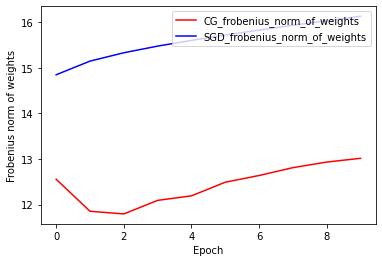

In [13]:
plt.plot(
    CG_frobenius_norm_of_weight,
    color='r',
    label='CG_frobenius_norm_of_weights')
plt.plot(
    SGD_frobenius_norm_of_weight,
    color='b',
    label='SGD_frobenius_norm_of_weights')
plt.xlabel('Epoch')
plt.ylabel('Frobenius norm of weights')
plt.legend(loc=1)

# 훈련 및 검증 정확성: CG vs SGD


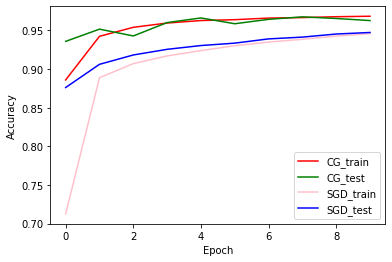

In [14]:
plt.plot(history_cg.history['accuracy'], color='r', label='CG_train')
plt.plot(history_cg.history['val_accuracy'], color='g', label='CG_test')
plt.plot(history_sgd.history['accuracy'], color='pink', label='SGD_train')
plt.plot(history_sgd.history['val_accuracy'], color='b', label='SGD_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)